# Introduction

<br>

For this project, I decided to look upon some weather data to see what I could make happen. I gathered the data from the Environmental Protection Agency (link:https://www.epa.gov/ceam/meteorological-data-arizona) and decided to look at daily Phoenix data. 

<br>
My first thought in exploring the data would be to try and create a model that could predict the temperature and to accomplish this, I tried to implement a k-nearest neighbors model. 

Let's import the data and take a peek

## Reading and munging the data

In [1]:
## RUN THIS CELL

library(MASS)
library(kknn)
library(tidyverse)
library(readxl)

weather = read_excel("arizonaWeather.xlsx", col_names = FALSE)[,4] #read in only the temperature data 


colnames(weather) = 'Temp'

n = nrow(weather)  #number of observatons

xall = 1:n  # Days since the start of the dataset. The provided timestamp in the dataset is unnecessary here
yall = weather$Temp  # Temp

df = data.frame(xall, yall)

dim(df)

head(df)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



[1] 10957     2

,xall,yall
,<int>,<dbl>
1,1,8.1
2,2,8.0
3,3,9.6
4,4,10.1
5,5,12.2
6,6,10.7


Seeing that the data frame is about 11,000 observations, I will divide the data into testing and training sets accordingly.

I elect to use a 70-30 split, so 7700 random entries will be in the training set and the remaining 3300 or so will be testing points.

## Making the Train and Test data

In [2]:
div = sample(x=1:n, size=7700, replace=FALSE)

train = df[div,]
test = df[-div,]


Now, I am going to set up the process to determine a decent amount of nearby points, k, to heavily consider in the regression process.

To do so, the k value is judged based on if it produces the lowest RMSE.

## Determining the best value for k

In [4]:
# laying out our k's to test
kv = 1:350
nk=length(kv)

# pre allocating the RMSEs
outRMSE = rep(0,nk)
inRMSE = rep(0,nk) 

# your code here
testLength = dim(test)
testLength = testLength[1]

trainLength = dim(train)
trainLength = trainLength[1]

for (i in kv) {
    outSum = 0
    inSum = 0
    
    kmod = kknn(yall ~ xall, train=train, test=test, k=i, kernel="cos")
    
    for (x in 1:testLength){
        outSum = outSum + (kmod$fitted[x] - test$yall[x])**2
    }
    outRMSE[i]  = sqrt(outSum/testLength)
    
    kmodtr = kknn(yall ~ xall, train=train, test=train, k=i, kernel="cos")

    for (x in 1:trainLength){
        inSum = inSum + (kmodtr$fitted[x] - train$yall[x])**2
    }
    inRMSE[i]  = sqrt(inSum/trainLength)
}



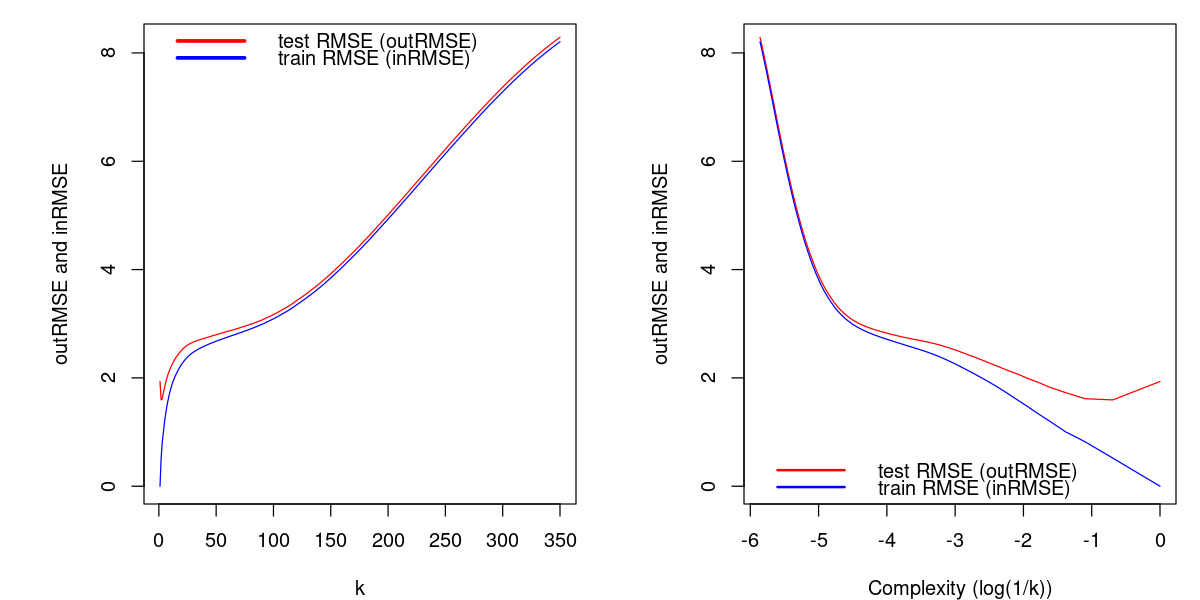

In [8]:

options(repr.plot.width=10, repr.plot.height=5)

par(mfrow=c(1,2),mar=c(4,6,1,1))

plot(kv,outRMSE,type="l", xlab="k",ylab="outRMSE and inRMSE", col="red",ylim=range(inRMSE))

lines(kv,inRMSE,col="blue")

legend(x = "topleft", legend = c("test RMSE (outRMSE)", "train RMSE (inRMSE)"), lty = c(1, 1), col = c("red", "blue"),           # Line colors
       lwd = 3, bty = "n") 


plot(log(1/kv),outRMSE,type="l", xlab="Complexity (log(1/k))",ylab="outRMSE and inRMSE", col="red",ylim=range(inRMSE))

lines(log(1/kv),inRMSE,col="blue")

legend(x = "bottomleft", legend = c("test RMSE (outRMSE)", "train RMSE (inRMSE)"), lty = c(1, 1), col = c("red", "blue"),           # Line colors
       lwd = 2, bty = "n")   



In [9]:

kbest = which.min(outRMSE)


kbest

[1] 2

Yikes, that's not good.

That means that in the regression process, the two nearest points to any given point are going to have the most effect on the regression line.

A k value that low is going to lead to a very noisy graph and it means our model is likely going to be overfitting the data as it is too persuasive to immediate nearby values. 

Lets take a look at what the graph looks like.

## Graphs

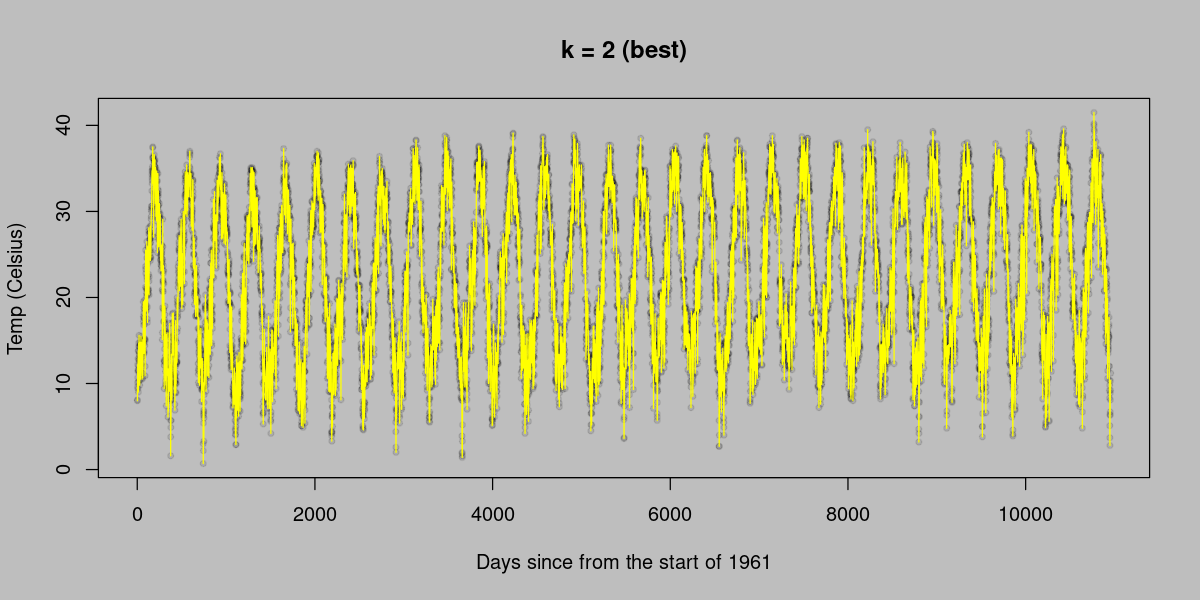

In [14]:
sortedxall = data.frame(xall=sort(df$xall))
kmodbest = kknn(yall~xall, df, test=sortedxall, k=kbest,kernel="cos")
par(bg = "gray")
plot(df,pch=20,col=rgb(0,0,0,0.1), xlab="Days since from the start of 1961", ylab="Temp (Celsius)", main="k = 2 (best)")
lines(sortedxall$xall, kmodbest$fitted, col="yellow")

As suspected, the resulting model is very noisy, to the point where the actual data values are not really visible.

This is likely partially due to the fact that the data is sine-wave-like in nature, although the attempt to combat that was made by adjusting the kknn kernel function parameter to cosine.

Lets take a look at some other potential values for k and see how that would affect the model


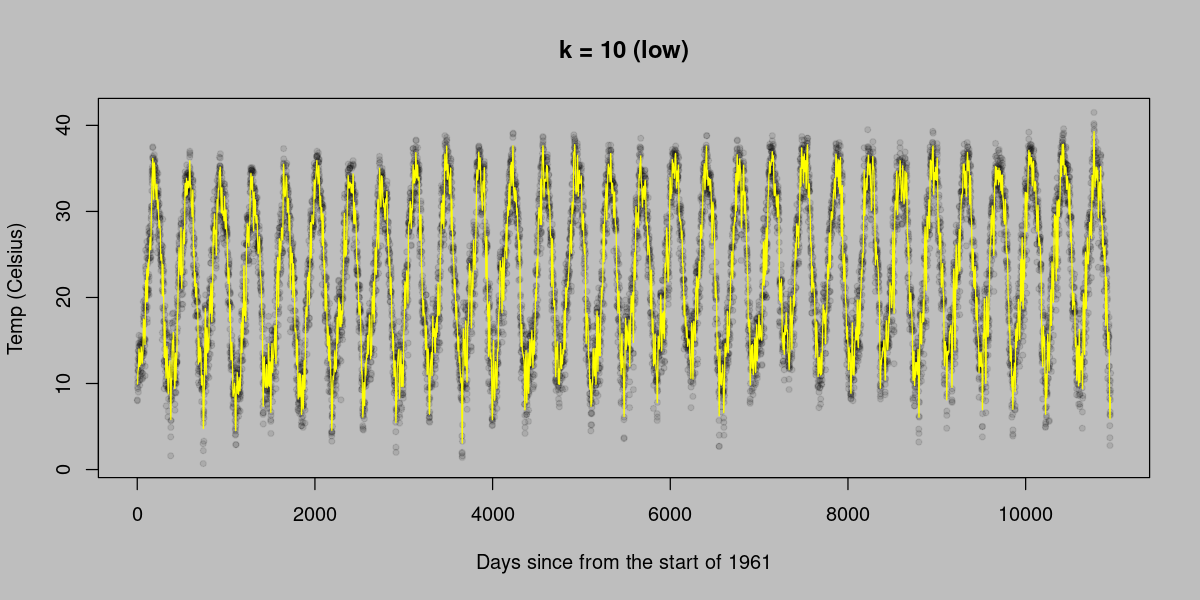

In [19]:
sortedxall = data.frame(xall=sort(df$xall))
kmodmid = kknn(yall~xall, df, test=sortedxall, k=10,kernel="cos")
par(bg = "gray")
plot(df,pch=20,col=rgb(0,0,0,0.1), xlab="Days since from the start of 1961", ylab="Temp (Celsius)", main="k = 10 (low)")

lines(sortedxall$xall, kmodmid$fitted, col="yellow")

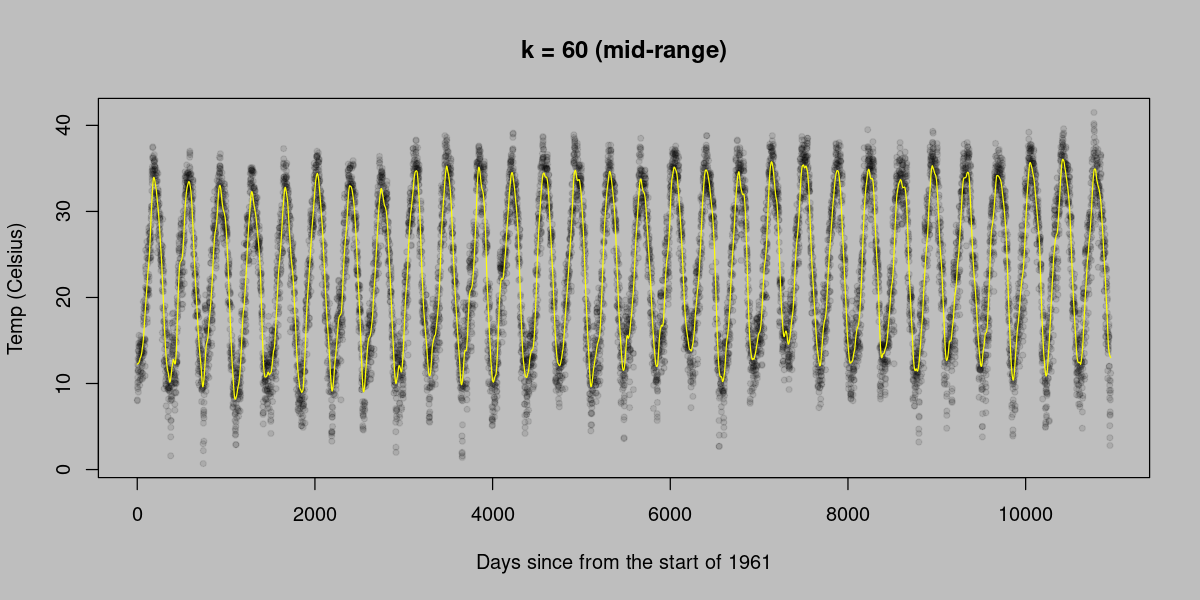

In [18]:
sortedxall = data.frame(xall=sort(df$xall))
kmodmid = kknn(yall~xall, df, test=sortedxall, k=60,kernel="cos")
par(bg = "gray")
plot(df,pch=20,col=rgb(0,0,0,0.1), xlab="Days since from the start of 1961", ylab="Temp (Celsius)", main="k = 60 (mid-range)")

lines(sortedxall$xall, kmodmid$fitted, col="yellow")

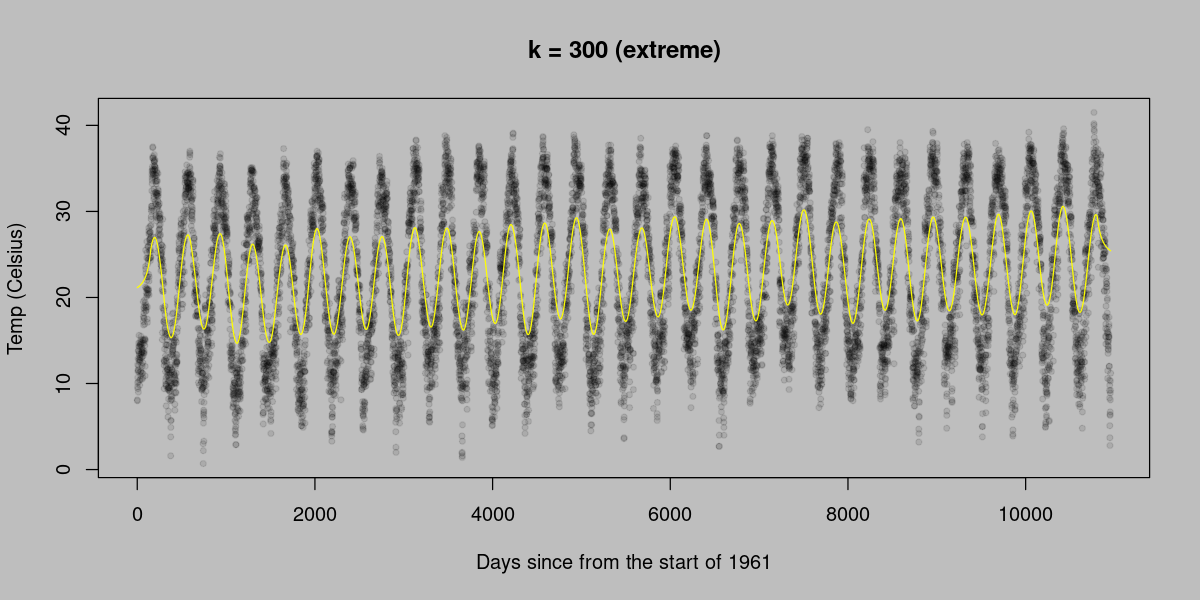

In [15]:
sortedxall = data.frame(xall=sort(df$xall))
kmodhigh = kknn(yall~xall, df, test=sortedxall, k=300,kernel="cos")
par(bg = "gray")
plot(df,pch=20,col=rgb(0,0,0,0.1), xlab="Days since from the start of 1961", ylab="Temp (Celsius)", main="k = 300 (extreme)")
lines(sortedxall$xall, kmodhigh$fitted, col="yellow")

## Further Discussion and Continuation

As expected, when we pushed our value of k to be greater than our calculated value, we saw an immediate loss of representation in the peaks and troughs of the graphs, with the severity only increasing as the days went on. By the time k reaches 300, the model has simply become unrecognizable in comparison to the data.


While this is reassuring in the sense that we found a somewhat optimal value for k, the conclusions we can draw from this discovery are slim to none because of the sheer noisiness of the model. 

If I was able to implement more of the data in the original set, the model could have potentially worked out better but doing so would simply advocate for the use of a different kind of model.

Unfortunately, due to the nature of this data, the k nearest neighbors method I implemented did not really yield any exciting results. So, to try and gain some kind of knowledge, I will continue on with the data set but in a new direction: make a model to guess what season it is, given some common weather values.

But more on that in Python.